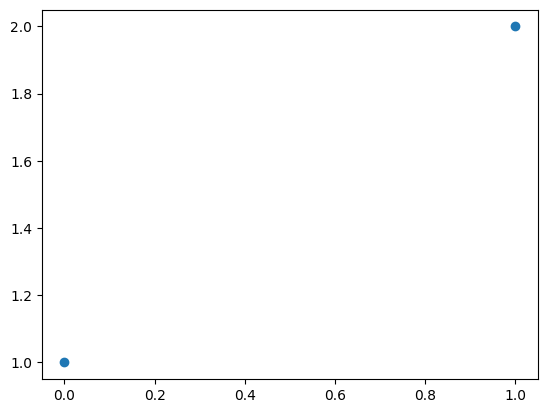

In [9]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
import seis_invert
import seis_prior
import seis_nn
import cupy as cp
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

10000
FlatVel_A


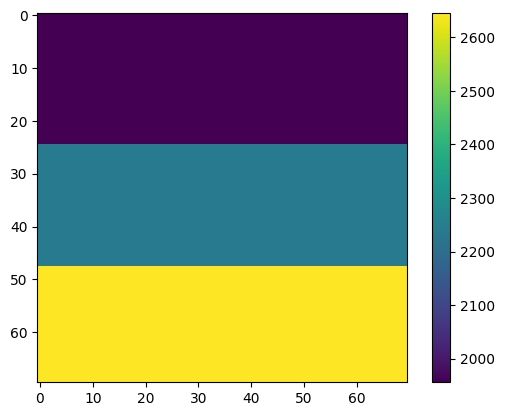

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()
d = data[6001]
print(d.family)
d.load_to_memory()
plt.figure()
plt.imshow(cp.asnumpy(d.velocity.data));plt.colorbar();#plt.clim([-3,3])

In [10]:
# TODO: don't use seis_correct, bigger variations, velB
seis_correct = seis_forward.vel_to_seis(d.velocity, d.seismogram)[0]
d_guess = seis_nn.make_default_pretrained().model([d])[0]
# offset_vector = cp.array(1e1*np.random.default_rng(seed=0).normal(0,1,size=d.velocity.to_vector().shape), dtype=kgs.base_type_gpu)
# velocity_offset = copy.deepcopy(d.velocity)
# velocity_offset.from_vector(velocity_offset.to_vector() + offset_vector)
# prior = seis_prior.RowTotalVariation(λ=1e-20)
# basis_functions = prior.basis_functions()
#print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(d.velocity.to_vector())), seis_correct.to_vector(), prior, basis_functions))
#print(seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(velocity_offset.to_vector())), seis_correct.to_vector(), prior, basis_functions))
#print('base RMS', kgs.rms(cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data)))
#print('base seis diff', kgs.rms(cp.asnumpy(seis_correct.to_vector() - seis_forward.vel_to_seis(velocity_offset, seis_correct)[0].to_vector())))

F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\bartley_unet2d_convnext_seed1_epochbest_FT.pth
Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
Loading:  F:/seismic/models/brendan\bartley_unet2d_convnext_seed2_epochbest_FT.pth
Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
n_models: 2


TypeError: pad(): argument 'input' (position 1) must be Tensor, not list

In [4]:
importlib.reload(seis_invert)
λ_vals = 10**np.linspace(-20,0,5)
#λ_vals = [10**-9]
maxiter=1000
res = [[],[],[]]
rms_vals = [[],[],[]]
cost_vals = [[],[],[]]
res_vals = [[],[],[]]

In [5]:
NN=3
for λ in λ_vals:    
    prior = seis_prior.RowTotalVariation(λ=λ)
    basis_functions = prior.basis_functions()
    seis_invert.true_vel = d.velocity
    res[0].append(seis_invert.seis_to_vel(seis_correct, d.velocity, prior, maxiter=maxiter))
    print('done1', λ)
    res[1].append(seis_invert.seis_to_vel(d.seismogram, d.velocity, prior,maxiter=maxiter))
    print('done2', λ)
    res[2].append(seis_invert.seis_to_vel(d.seismogram, d_guess.velocity_guess, prior,maxiter=maxiter))
    print('done2', λ)
    for ii in range(NN):
        rms_vals[ii].append(cp.asnumpy(kgs.rms(res[ii][-1].to_vector()-d.velocity.to_vector())))
        cost_vals[ii].append( cp.asnumpy(
            seis_invert.cost_and_gradient(cp.linalg.solve(basis_functions.T@basis_functions, basis_functions.T@(res[ii][-1].to_vector())), seis_correct.to_vector(), prior, basis_functions) ))
        res_vals[ii].append(cp.asnumpy(kgs.rms( kgs.rms( seis_correct.data - seis_forward.vel_to_seis(res[ii][-1], d.seismogram)[0].data ) )))
    print('RMS', λ, rms_vals[0], rms_vals[1])
    print('Cost', λ, cost_vals[0], cost_vals[1])
    print('res', λ, res_vals[0], res_vals[1])

1.0971057949745318e-19 0.0
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.0971057949745319e-09
        x: [ 1.956e+03  1.956e+03 ...  2.646e+03  1.956e+03]
      nit: 0
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 1
     njev: 1
done1 1e-20
4.834145763446854e-10 0.0
7.279254549069768e-06 0.12070576703053316
3.3957660809072717e-10 0.0005342000667743835
2.3914325229092487e-09 0.007141856200218825
3.305659098820549e-10 0.0007169523230262803
3.1705192859558724e-10 0.0012033467406100014
3.44677211848027e-10 0.003419029150151756
3.1365994089273516e-10 0.0015762890791724783
3.1237330658781916e-10 0.0022594811129331444
3.1042038467934014e-10 0.0026263376988567948
3.080177976279803e-10 0.0033720261247967387
3.08390033800314e-10 0.00456194025364645
3.068909209241642e-10 0.0038889862684177213
3.0540032550424

In [6]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


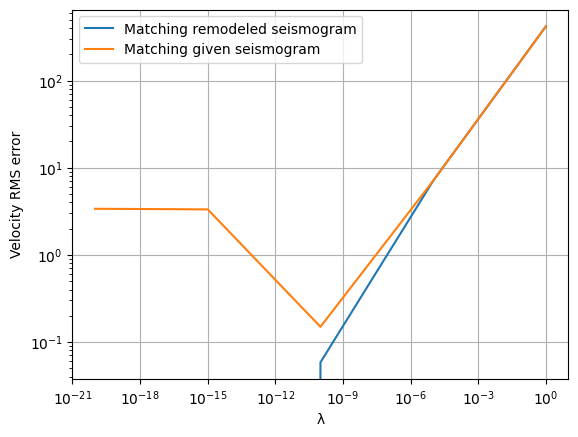

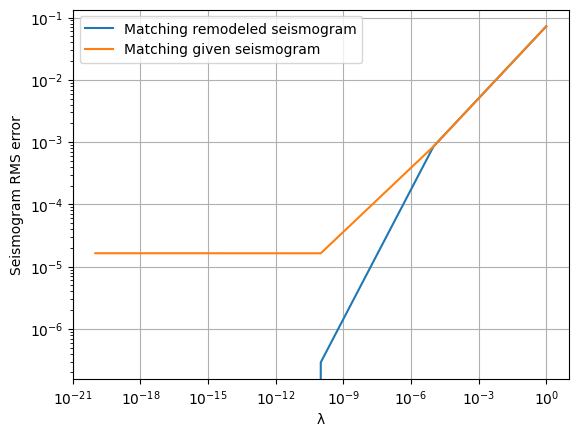

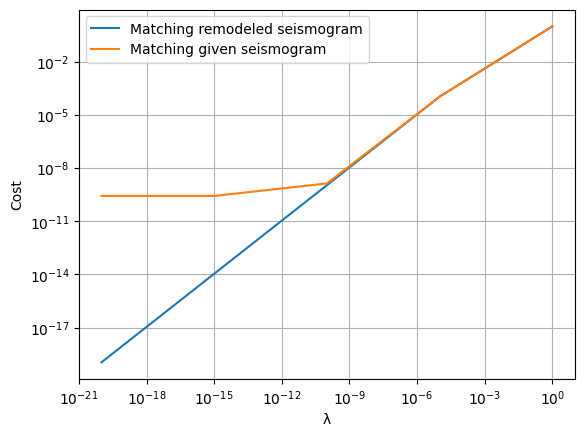

In [7]:
for to_plot in [[rms_vals, 'Velocity RMS error'], [res_vals, 'Seismogram RMS error'], [cost_vals, 'Cost']]:
    plt.figure()
    plt.loglog(λ_vals, to_plot[0][0])
    plt.loglog(λ_vals, to_plot[0][1])
    plt.loglog(λ_vals, to_plot[0][2])
    plt.xlabel('λ')
    plt.ylabel(to_plot[1])
    plt.grid(True)
    plt.legend(('Matching remodeled seismogram', 'Matching given seismogram', 'Matching given seismogram, starting from guess'))

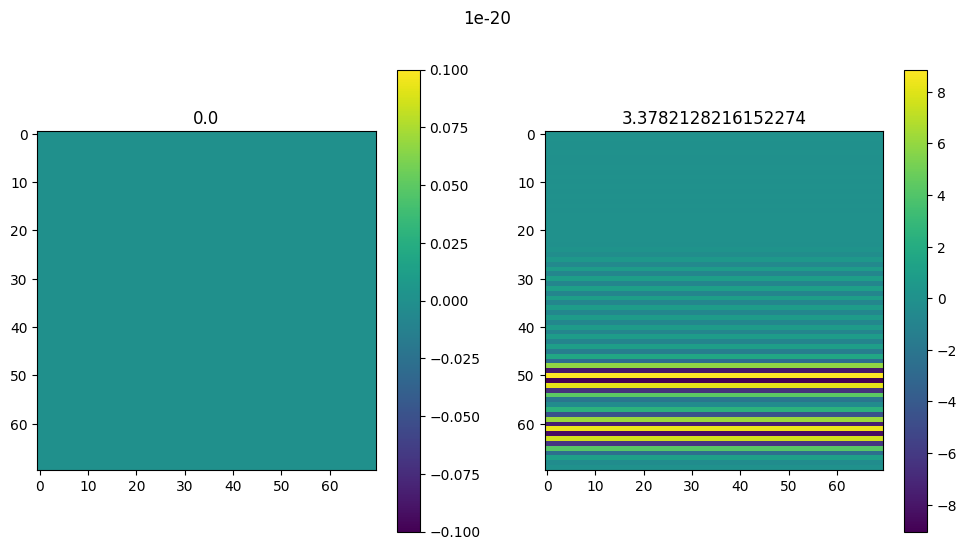

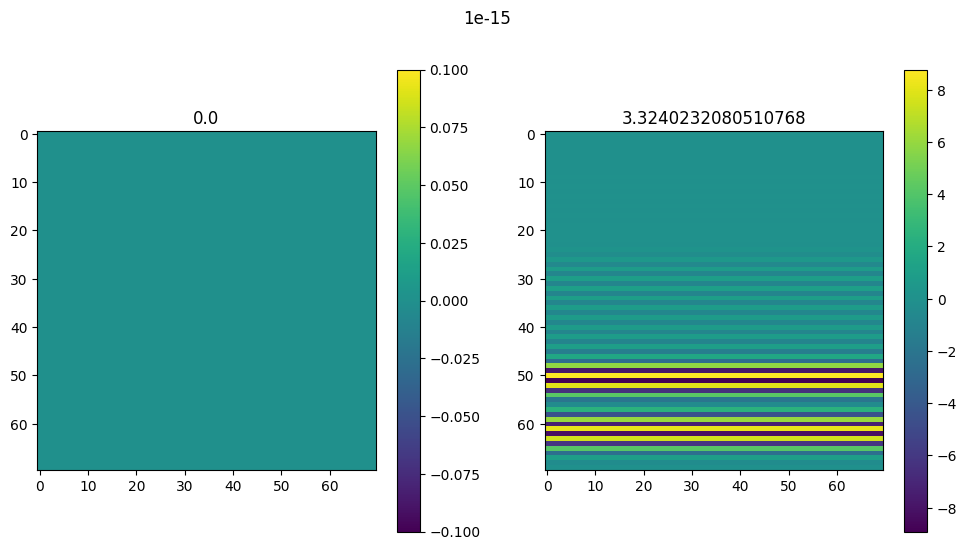

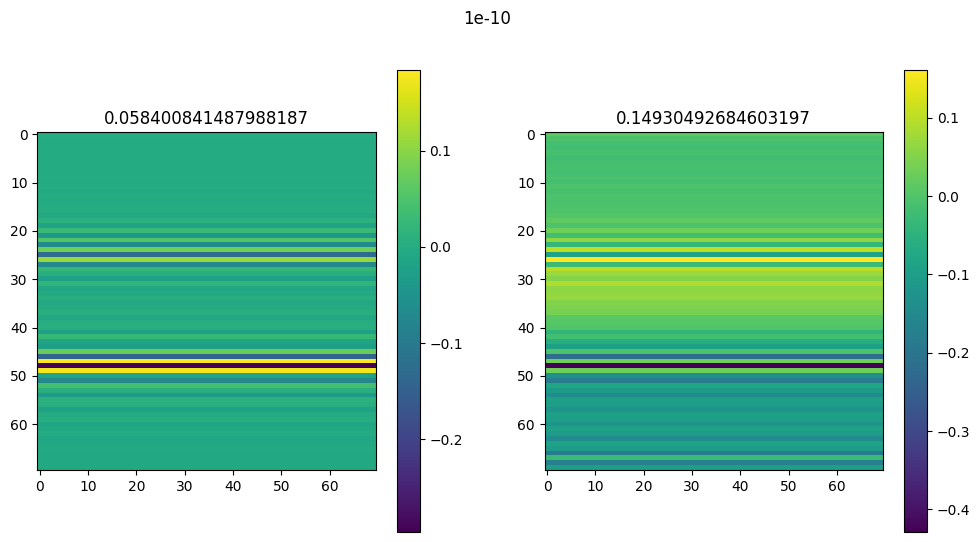

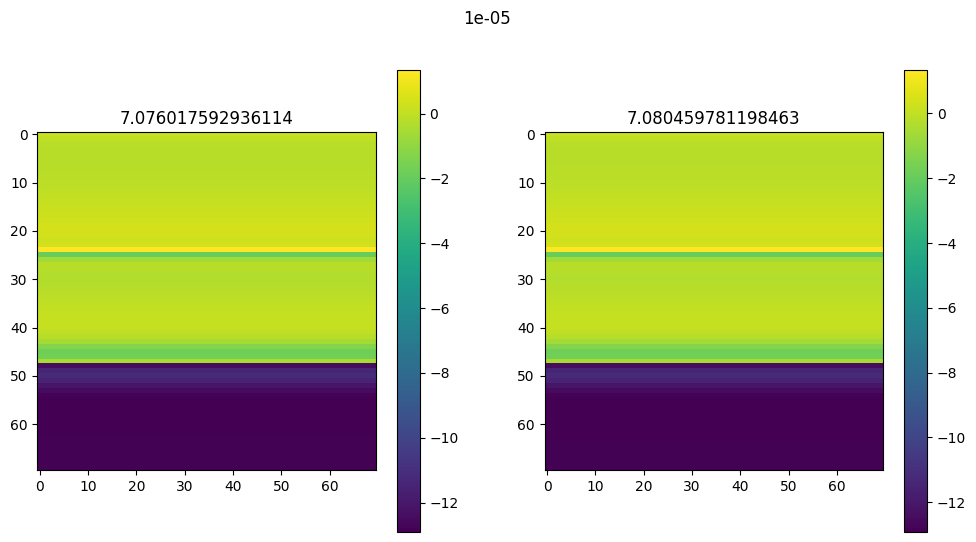

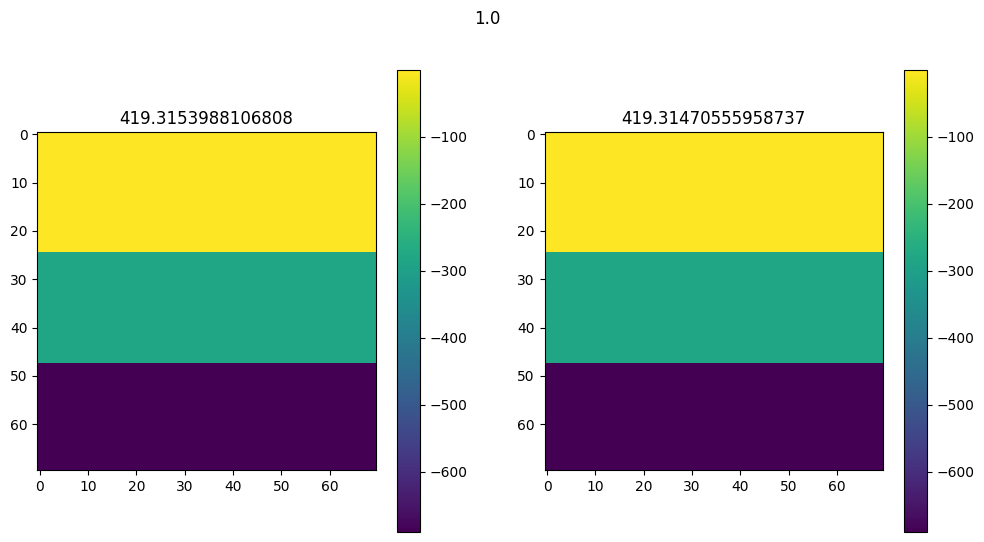

In [13]:
#plt.figure()
#plt.imshow( cp.asnumpy(velocity_offset.data - d.velocity.data));plt.colorbar()
#plt.figure()
#plt.imshow( cp.asnumpy(cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data));plt.colorbar()
#plt.title(kgs.rms (cp.mean(velocity_offset.data - d.velocity.data,axis=0)[:,None] + 0*d.velocity.data))
for i,λ in enumerate(λ_vals): 
    _,ax=plt.subplots(1,2,figsize=(12,6))
    for ii in range(NN):
        plt.sca(ax[ii])
        plt.imshow( cp.asnumpy(res[ii][i].data - d.velocity.data));plt.colorbar()
        plt.title(rms_vals[ii][i])
    plt.suptitle(λ)

In [ ]:
rms_vals

In [ ]:
cost_vals

In [ ]:
res_vals

In [ ]:
λ_vals = [-13]

In [12]:
NN=2